# **IMPORTING LIBERARIES**

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns

# For cleaner plots
sns.set(style='whitegrid')

# **Data Loading**

In [4]:
# Load ratings data
ratings = pd.read_csv("Movies Dataset/ratings.dat", sep="::", engine='python',
                      names=["UserID", "MovieID", "Rating", "Timestamp"], encoding="latin1")

# Preview data
ratings.head()


,UserID,MovieID,Rating,Timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


In [5]:
# Load users data
users = pd.read_csv("Movies Dataset/users.dat", sep="::", engine='python',
                    names=["UserID", "Gender", "Age", "Occupation", "Zip-code"], encoding="latin1")
users.head()

,UserID,Gender,Age,Occupation,Zip-code
0,1,F,1,10,48067
1,2,M,56,16,70072
2,3,M,25,15,55117
3,4,M,45,7,02460
4,5,M,25,20,55455


In [6]:
# Load movies data
movies = pd.read_csv("Movies Dataset/movies.dat", sep="::", engine='python',
                     names=["MovieID", "Title", "Genres"], encoding="latin1")

movies.head()

,MovieID,Title,Genres
0,1,Toy Story (1995),Animation|Children's|Comedy
1,2,Jumanji (1995),Adventure|Children's|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama
4,5,Father of the Bride Part II (1995),Comedy


## data visualization

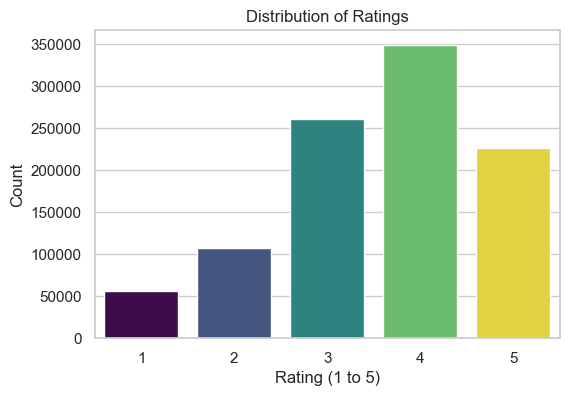

In [13]:
plt.figure(figsize=(6,4))
sns.countplot(data=ratings, x="Rating", hue="Rating" ,palette="viridis" ,legend=False)
plt.title("Distribution of Ratings")
plt.xlabel("Rating (1 to 5)")
plt.ylabel("Count")
plt.show()

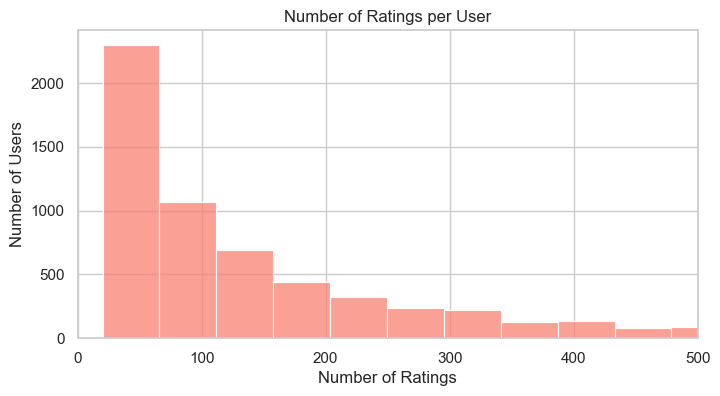

In [14]:
ratings_per_user = ratings.groupby("UserID").size()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_user, bins=50, kde=False, color='salmon')
plt.title("Number of Ratings per User")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Users")
plt.xlim(0, 500)
plt.show()


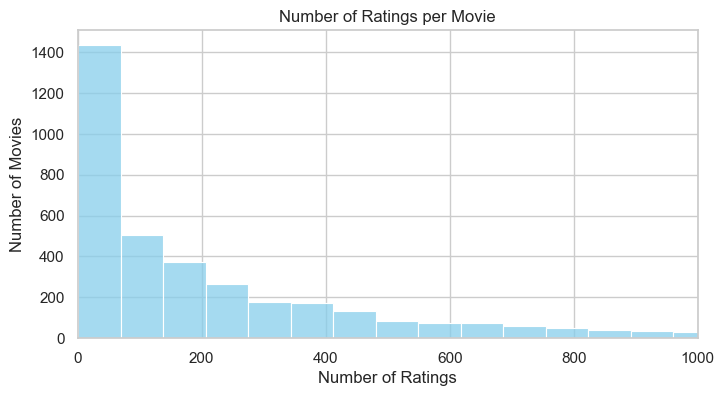

In [17]:
ratings_per_movie = ratings.groupby("MovieID").size()

plt.figure(figsize=(8,4))
sns.histplot(ratings_per_movie, bins=50, kde=False, color='skyblue')
plt.title("Number of Ratings per Movie")
plt.xlabel("Number of Ratings")
plt.ylabel("Number of Movies")
plt.xlim(0, 1000)
plt.show()


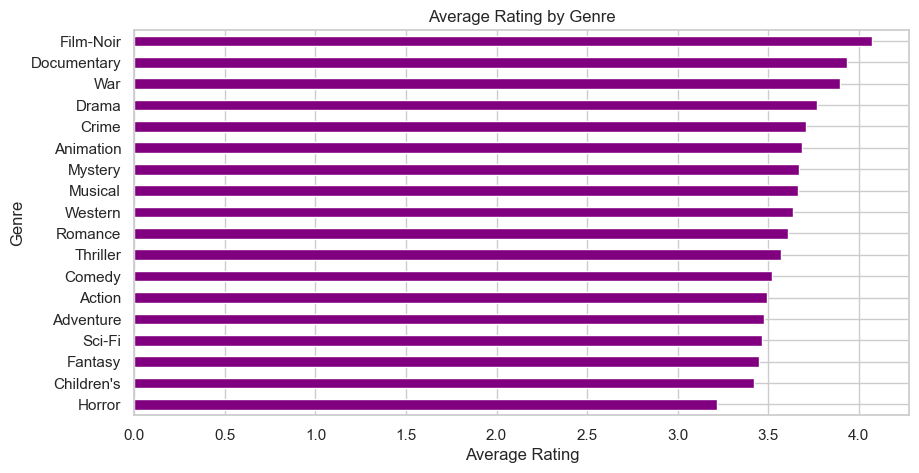

In [18]:
# First, explode genres
movies_exploded = movies.copy()
movies_exploded["Genres"] = movies_exploded["Genres"].str.split("|")
movies_exploded = movies_exploded.explode("Genres")

# Merge with ratings
movie_ratings = pd.merge(ratings, movies_exploded, on="MovieID")

# Group by genre
genre_ratings = movie_ratings.groupby("Genres")["Rating"].mean().sort_values()

plt.figure(figsize=(10,5))
genre_ratings.plot(kind='barh', color='purple')
plt.title("Average Rating by Genre")
plt.xlabel("Average Rating")
plt.ylabel("Genre")
plt.show()


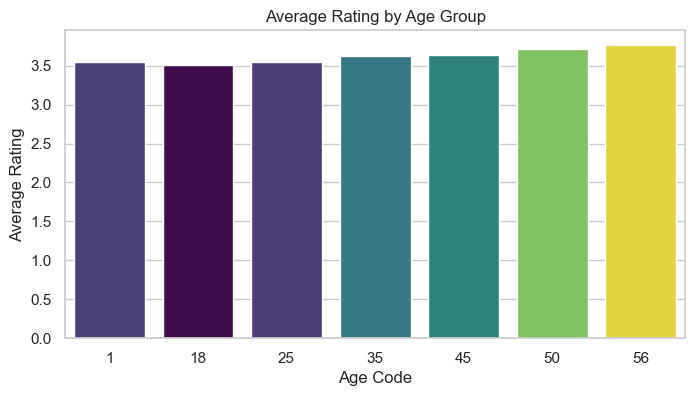

In [37]:
# Merge users and ratings
user_ratings = pd.merge(ratings, users, on="UserID")

age_rating = user_ratings.groupby("Age")["Rating"].mean()

plt.figure(figsize=(8,4))
sns.barplot(x=age_rating.index, y=age_rating.values, hue=age_rating.values, legend=False , palette="viridis")
plt.title("Average Rating by Age Group")
plt.xlabel("Age Code")
plt.ylabel("Average Rating")
plt.show()

# Create the User-Item Rating Matrix

In [22]:
# Create the user-item rating matrix
user_item_matrix = ratings.pivot_table(index='UserID', columns='MovieID', values='Rating')

# Fill missing values with 0 for cosine similarity
user_item_filled = user_item_matrix.fillna(0)


## Compute User Similarity

In [ ]:
# Compute cosine similarity between users
user_similarity = cosine_similarity(user_item_filled)

# Wrap it in a DataFrame for easier indexing
user_similarity_df = pd.DataFrame(user_similarity, 
                                   index=user_item_matrix.index, 
                                   columns=user_item_matrix.index)

# Recommend Movies for a Target User Already Present User

In [26]:
def recommend_movies(target_user, user_item_matrix, similarity_df, movies_df, k=5):
    # Step 1: Get similarity scores
    sim_scores = similarity_df.loc[target_user].drop(index=target_user)

    # Step 2: Find top similar users
    top_users = sim_scores.sort_values(ascending=False).head(k).index

    # Step 3: Get their ratings
    neighbor_ratings = user_item_matrix.loc[top_users]

    # Step 4: Average their ratings (weighted or unweighted)
    avg_ratings = neighbor_ratings.mean(axis=0)

    # Step 5: Drop movies the target user already rated
    seen_movies = user_item_matrix.loc[target_user]
    unseen_movies = avg_ratings[seen_movies.isna()]

    # Step 6: Sort unseen movies by predicted rating
    top_recs = unseen_movies.sort_values(ascending=False).head(10)

    # Step 7: Get titles
    recommended_titles = movies_df[movies_df["MovieID"].isin(top_recs.index)][["MovieID", "Title"]]
    recommended_titles["PredictedRating"] = recommended_titles["MovieID"].map(top_recs)

    return recommended_titles.sort_values("PredictedRating", ascending=False)


## Recommend for User 10

In [28]:
recommendations = recommend_movies(50, user_item_matrix, user_similarity_df, movies)
print(recommendations)

      MovieID                                 Title  PredictedRating
69         70            From Dusk Till Dawn (1996)              5.0
1228     1248                  Touch of Evil (1958)              5.0
1230     1250  Bridge on the River Kwai, The (1957)              5.0
1249     1269           Arsenic and Old Lace (1944)              5.0
1264     1284                 Big Sleep, The (1946)              5.0
1366     1387                           Jaws (1975)              5.0
1890     1959                  Out of Africa (1985)              5.0
3090     3159                  Fantasia 2000 (1999)              5.0
3198     3267                   Mariachi, El (1992)              5.0
3412     3481                  High Fidelity (2000)              5.0


# Predictiuon for New User (He/She will Enter 3 Movie liked)

In [29]:
# Example 3 movies user likes
favorite_titles = ["Toy Story (1995)", "Jumanji (1995)", "Grumpier Old Men (1995)"]

In [30]:
# Filter from movies dataset
favorite_movies = movies[movies["Title"].isin(favorite_titles)]

# Explode genres for easier matching
favorite_genres = favorite_movies["Genres"].str.split("|").explode()

# Get unique liked genres
liked_genres = set(favorite_genres)

print("Liked genres:", liked_genres)


Liked genres: {'Animation', 'Adventure', 'Fantasy', "Children's", 'Comedy', 'Romance'}


In [31]:
def genre_overlap_score(genres_str, liked_genres):
    genres = set(genres_str.split("|"))
    return len(genres & liked_genres)

# Create score column
movies["GenreScore"] = movies["Genres"].apply(lambda g: genre_overlap_score(g, liked_genres))


In [32]:
# Get popularity and rating info
movie_stats = ratings.groupby("MovieID").agg({
    "Rating": ["mean", "count"]
})
movie_stats.columns = ["AvgRating", "RatingCount"]
movie_stats.reset_index(inplace=True)

# Merge with movies
movies_scored = pd.merge(movies, movie_stats, on="MovieID", how="left")


In [35]:
# Remove input movies
recommend_candidates = movies_scored[~movies_scored["Title"].isin(favorite_titles)]

# Final score: weighted sum (you can tweak this)
recommend_candidates["FinalScore"] = (
    recommend_candidates["GenreScore"] * 1.5 +
    recommend_candidates["AvgRating"].fillna(0) * 1.0 +
    (recommend_candidates["RatingCount"].fillna(0) / 1000)
)

# Top 10 recommendations
recommendations = recommend_candidates.sort_values("FinalScore", ascending=False).head(10)

recommendations[["Title", "Genres", "AvgRating", "RatingCount", "FinalScore"]]


C:\Users\bscs2213\AppData\Local\Temp\ipykernel_17952\1156067771.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recommend_candidates["FinalScore"] = (


,Title,Genres,AvgRating,RatingCount,FinalScore
1058,Willy Wonka and the Chocolate Factory (1971),Adventure|Children's|Comedy|Fantasy,3.861386,1313.0,11.174386
1179,"Princess Bride, The (1987)",Action|Adventure|Comedy|Romance,4.303710,2318.0,11.121710
2012,"Little Mermaid, The (1989)",Animation|Children's|Comedy|Musical|Romance,3.756522,1035.0,10.791522
667,Space Jam (1996),Adventure|Animation|Children's|Comedy|Fantasy,2.619893,563.0,10.682893
2011,Lady and the Tramp (1955),Animation|Children's|Comedy|Musical|Romance,3.804398,864.0,10.668398
257,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Fantasy|Sci-Fi,4.453694,2991.0,10.444694
3045,Toy Story 2 (1999),Animation|Children's|Comedy,4.218927,1585.0,10.303927
255,"Kid in King Arthur's Court, A (1995)",Adventure|Children's|Comedy|Fantasy|Romance,2.423611,144.0,10.067611
2286,"Bug's Life, A (1998)",Animation|Children's|Comedy,3.854375,1703.0,10.057375
1985,"Honey, I Shrunk the Kids (1989)",Adventure|Children's|Comedy|Fantasy|Sci-Fi,2.933014,1045.0,9.978014
